### Fast Style Transfer (Test)  
##### The program is only used for the graduate paper.
##### by Zian Gu

In [1]:
from __future__ import print_function
import sys

sys.path.insert(0, 'src')
import transform, numpy as np, vgg, pdb, os
import scipy.misc
import tensorflow as tf
from utils import save_img, get_img, exists, list_files
from argparse import ArgumentParser
from collections import defaultdict
import time
import json
import subprocess
import numpy
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 4
DEVICE = '/gpu:0'

# get img_shape
def ffwd(data_in, paths_out, checkpoint_dir, device_t='/gpu:0', batch_size=4):
    assert len(paths_out) > 0
    is_paths = type(data_in[0]) == str
    if is_paths:
        assert len(data_in) == len(paths_out)
        img_shape = get_img(data_in[0]).shape
    else:
        assert data_in.size[0] == len(paths_out)
        img_shape = X[0].shape

    g = tf.Graph()
    batch_size = min(len(paths_out), batch_size)
    curr_num = 0
    soft_config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
    soft_config.gpu_options.allow_growth = True
    with g.as_default(), g.device(device_t), \
            tf.compat.v1.Session(config=soft_config) as sess:
        batch_shape = (batch_size,) + img_shape
        img_placeholder = tf.compat.v1.placeholder(tf.float32, shape=batch_shape,
                                                   name='img_placeholder')

        preds = transform.net(img_placeholder)
        saver = tf.compat.v1.train.Saver()
        if os.path.isdir(checkpoint_dir):
            ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)
            else:
                raise Exception("No checkpoint found...")
        else:
            saver.restore(sess, checkpoint_dir)

        num_iters = int(len(paths_out) / batch_size)
        for i in range(num_iters):
            pos = i * batch_size
            curr_batch_out = paths_out[pos:pos + batch_size]
            if is_paths:
                curr_batch_in = data_in[pos:pos + batch_size]
                X = np.zeros(batch_shape, dtype=np.float32)
                for j, path_in in enumerate(curr_batch_in):
                    img = get_img(path_in)
                    assert img.shape == img_shape, \
                        'Images have different dimensions. ' + \
                        'Resize images or use --allow-different-dimensions.'
                    X[j] = img
            else:
                X = data_in[pos:pos + batch_size]

            _preds = sess.run(preds, feed_dict={img_placeholder: X})
            for j, path_out in enumerate(curr_batch_out):
                save_img(path_out, _preds[j])
                img1 = np.clip(_preds[j], 0, 255).astype(np.uint8)
                plt.figure(dpi=300)
                plt.imshow(img1)
        remaining_in = data_in[num_iters * batch_size:]
        remaining_out = paths_out[num_iters * batch_size:]
    if len(remaining_in) > 0:
        ffwd(remaining_in, remaining_out, checkpoint_dir,
             device_t=device_t, batch_size=1)


def ffwd_to_img(in_path, out_path, checkpoint_dir, device='/cpu:0'):
    paths_in, paths_out = [in_path], [out_path]
    ffwd(paths_in, paths_out, checkpoint_dir, batch_size=1, device_t=device)


def ffwd_different_dimensions(in_path, out_path, checkpoint_dir,
                              device_t=DEVICE, batch_size=4):
    in_path_of_shape = defaultdict(list)
    out_path_of_shape = defaultdict(list)
    for i in range(len(in_path)):
        in_image = in_path[i]
        out_image = out_path[i]
        shape = "%dx%dx%d" % get_img(in_image).shape
        in_path_of_shape[shape].append(in_image)
        out_path_of_shape[shape].append(out_image)
    for shape in in_path_of_shape:
        print('Processing images of shape %s' % shape)
        ffwd(in_path_of_shape[shape], out_path_of_shape[shape],
             checkpoint_dir, device_t, batch_size)

INFO:tensorflow:Restoring parameters from checkpoints/test.ckpt


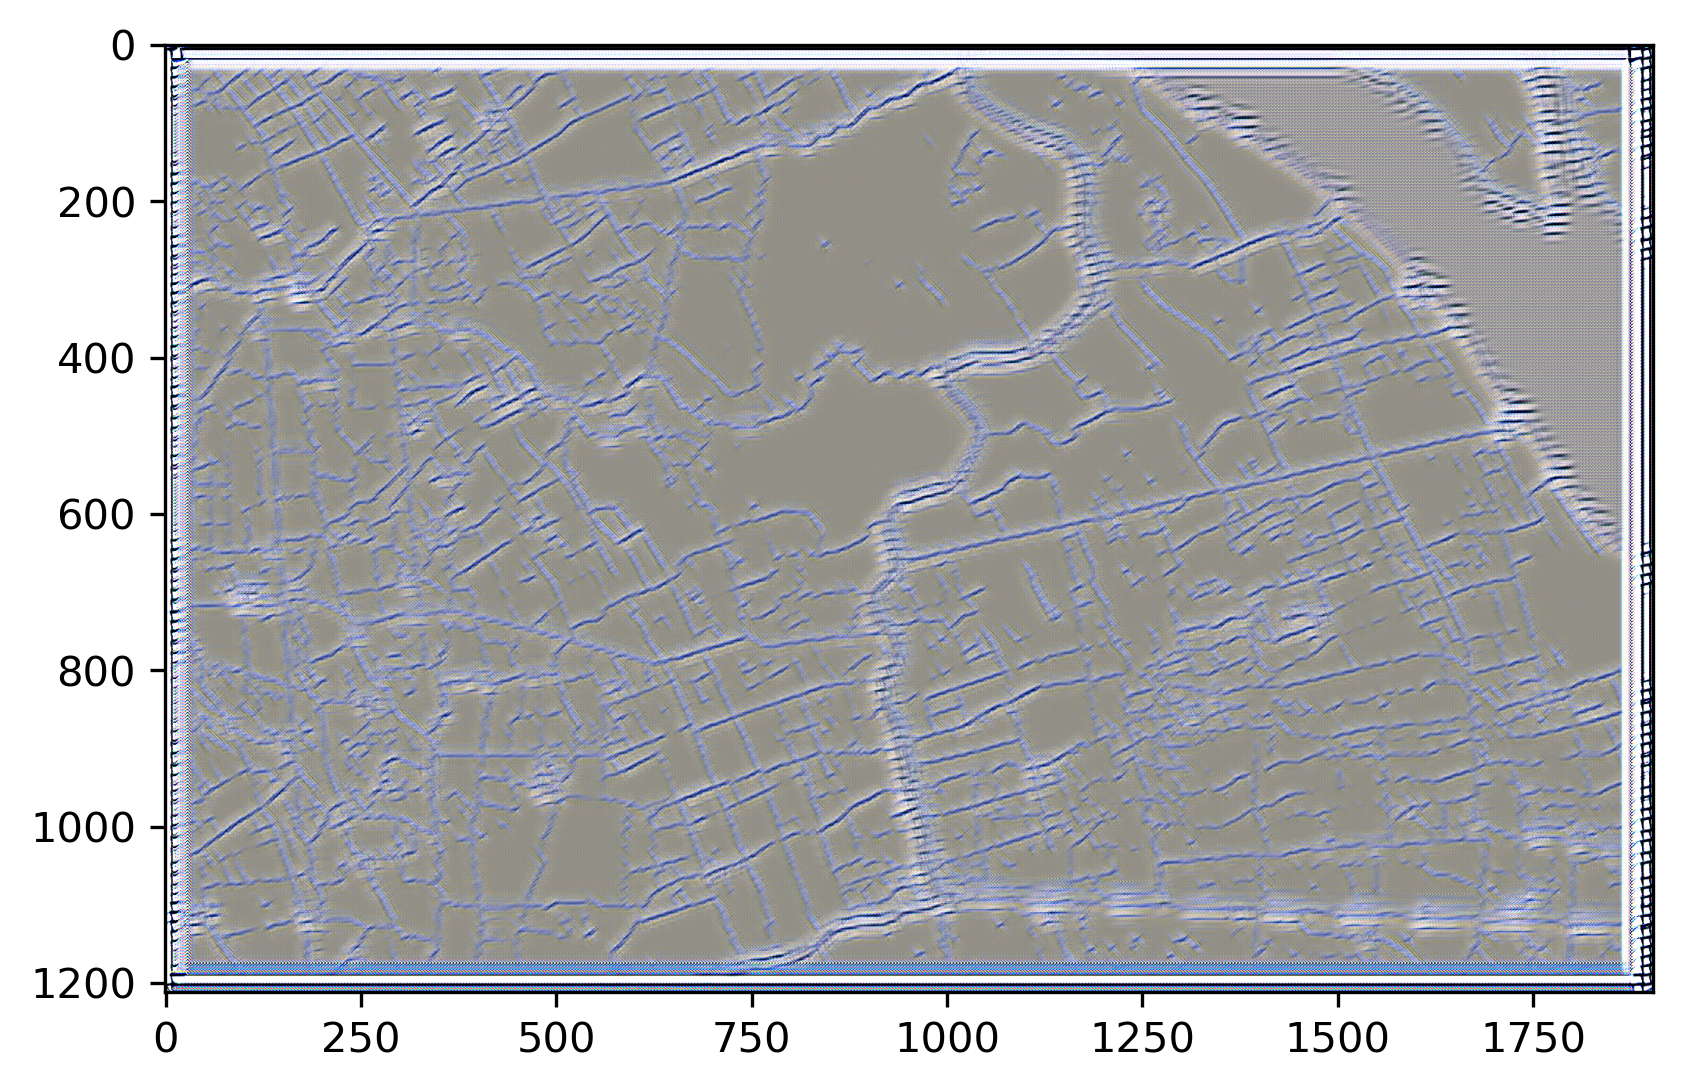

In [3]:
in_path = 'data/c1.jpg'
out_path = 'out'
checkpoint_dir = 'checkpoints/test.ckpt'
device = DEVICE
batch_size = BATCH_SIZE
# batch_size = 1
allow_different_dimensions = False

if not os.path.isdir(in_path):
    if os.path.exists(out_path) and os.path.isdir(out_path):
        out_path = \
            os.path.join(out_path, os.path.basename(in_path))
    else:
        out_path = out_path

    ffwd_to_img(in_path, out_path, checkpoint_dir,
                    device=device)
else:
    files = list_files(in_path)
    full_in = [os.path.join(in_path, x) for x in files]
    full_out = [os.path.join(out_path, x) for x in files]
    if allow_different_dimensions:
        ffwd_different_dimensions(full_in, full_out, checkpoint_dir,
                                    device_t=device, batch_size=batch_size)
    else:
        ffwd(full_in, full_out, checkpoint_dir, device_t=device,
                 batch_size=batch_size)